In [1]:
from ceo import constants, StopWatch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys

/home/ubuntu/CEO/python/ceo/zemax


# WFPT model demo with a DFS
This demo shows how to use the Wide Field Phasing Testbed (WFPT) model developed in CEO, using a single on-axis DFS.

Developed by: F. Quiros-Pacheco (GMTO)

Last update: 16/03/2022

## Initialize WFPT model
The WFPT package is located in **~/CEO/python/ceo/wfpt/** . There are so far four WFPT classes:
1. **wfpt_testbed**. The main WFPT testbed class that enables ray tracing through the WFPT Zemax model imported in CEO.
2. **wfpt_source**. The class that emulates the illumination source. It contains a "rays bundle" object to raytrace through the WFPT model, and a "CEO Source" object to enable WF propagation from the exit pupil of the WFPT testbed to the WFS. Currently only on-axis propagation possible.
3. **wfpt_sh48**. A wrapper class for the "CEO ShackHartmann" class that implements the SH48 model.
4. **wfpt_dfs**. A wrapper class for the "CEO DispersedFringeSensor" class that implements the DFS model.

In [2]:
from ceo import wfpt_testbed, wfpt_source, wfpt_dfs
from ceo import wfpt_visulib as visu

In [3]:
#----------------- WFPT model -----------------------------------
M2_baffle_diam=3.6  # size of M2 baffle
project_truss_onaxis=True # simulate truss shadows over central segment

wfpt = wfpt_testbed(M2_baffle_diam=M2_baffle_diam, project_truss_onaxis=project_truss_onaxis,
                   path_to_sensor='DFS')

In [4]:
#----------------- DFS Source model ------------------------------
dfs_band = 'J'
J_e0 = 1.88e12    # ph/s in J band over the GMT pupil
J_bkgd_mag = 16.2 # J-band sky bkgd (mag/arcsec^2); Tech Note GMT-02274, rev 2.4
fudged_J_bkgd_mag = J_bkgd_mag - 6.26

PupilArea = 368      # GMT pupil area [m^2]
dfs_mag = 12
fudged_dfs_mag = dfs_mag - 6.26

dfs_D = 27.41     # [m]
dfs_nPx = 481
src = wfpt_source(dfs_band, dfs_nPx, dfs_D, mag=fudged_dfs_mag)

In [5]:
#----------------- DFS model ------------------------------------
dfs = wfpt_dfs(src)

### Photometry check
In the cells below we used a *fudge factor* to boost the number of arriving photons from the guide star. This is to overcome a "bug" in the WFPT model in CEO that computes incorrectly the number of photons arriving at the WFS detectors.

In [6]:
#----> Expected number of arriving photons per second per squared meter
gs_nph_sec_m2 = J_e0*10**(-0.4*dfs_mag)/PupilArea

print("--> Photometry:")
#-----> Note: fudge factor needs to be considered below:
print('Number of simulated GS photons [ph/s/m^2]: %0.1f'%(src._gs.nPhoton[0] / 10**(0.4*6.26)))
print('Number of  expected GS photons [ph/s/m^2]: %0.1f'%(gs_nph_sec_m2))

--> Photometry:
Number of simulated GS photons [ph/s/m^2]: 81780.5
Number of  expected GS photons [ph/s/m^2]: 80967.4


## Propagate a flat wavefront and do calibrations
Activate the keyword **keep_rays_for_plot** if you want to show a ray diagram. Otherwise, set it to *False* to speed up the ray tracing.

In [7]:
keep_rays_for_plot = True

In [8]:
%%time
src.reset()
wfpt.reset()
wfpt.propagate(src, keep_rays_for_plot=keep_rays_for_plot)
opd0 = src._gs.phase.host()

CPU times: user 456 ms, sys: 332 ms, total: 788 ms
Wall time: 785 ms


### Show the WF at the exit pupil

on-axis WFE: 7.2 nm RMS


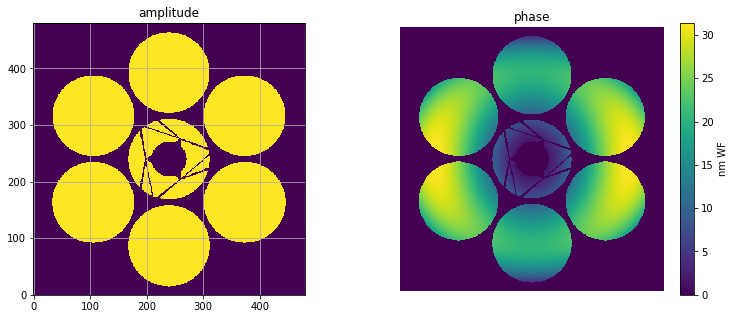

In [9]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((13,5))

ax1.imshow(src._gs.amplitude.host(), origin='lower',interpolation='None')
ax1.set_title('amplitude')
ax1.set_aspect('equal')
ax1.grid()

visu.show_wavefront(opd0*1e9, clb_label='nm WF', title='phase', fig=fig, ax=ax2)
print("on-axis WFE: %0.1f nm RMS"%(src._gs.phaseRms()*1e9))

### Show the rays diagram

In [10]:
if keep_rays_for_plot:
    xyz,klm,sid = wfpt.rays_data
    vig = src.rays.vignetting.host().ravel()>0

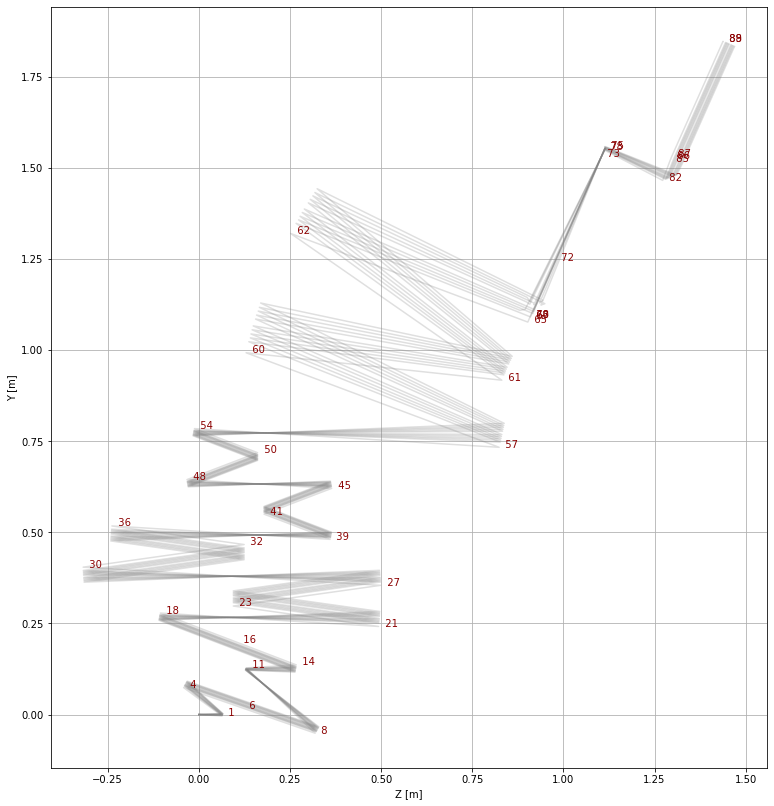

In [11]:
if keep_rays_for_plot:
    visu.show_rays(xyz, klm, sid, vig)

### DFS Calibration

In [12]:
dfs.calibrate(src)

In [13]:
wfpt.reset()
src.reset()
wfpt.propagate(src)
dfs.reset()
dfs.propagate(src)
dfs.fft()
fringes = dfs.get_data_cube(data_type='camera')

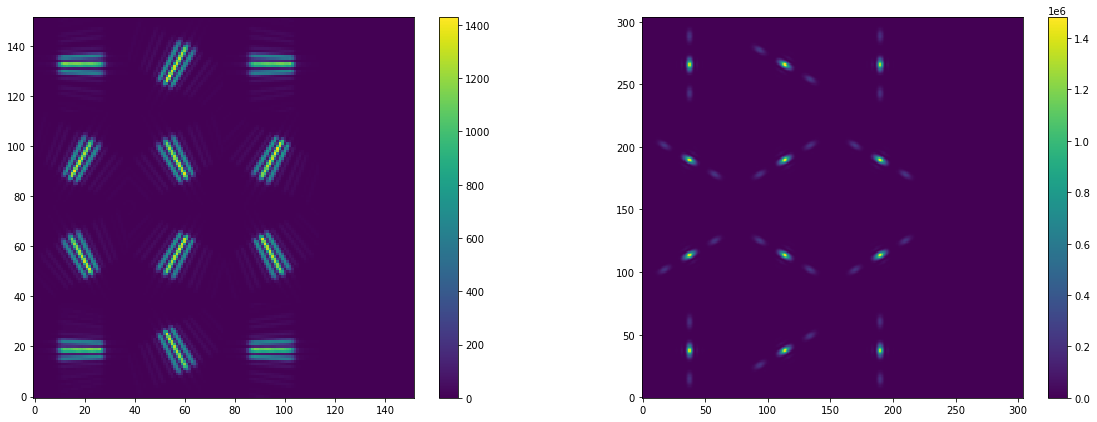

In [14]:
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((20,7))
h1 = ax1.imshow(dfs.camera.frame.host(),interpolation='None',origin='lower')
fig.colorbar(h1,ax=ax1)
h2 = ax2.imshow(dfs.fftlet.host(),interpolation='None',origin='lower')
fig.colorbar(h2,ax=ax2);

#### Set reference wavefront
We want to compute phase statistics after removing the reference wavefront.

In [15]:
wfpt.reset()
src.reset()

wfpt.propagate(src)
src.set_reference_wavefront()

## Apply commands to Active Mirrors and propagate wavefront
A state vector is defined containing the following degrees of freedom:
1. **M1_PTT**: 
    1. *segment piston*    (7)
    2. *segment tip-tilt*  (7x2)
2. **M2_PTT:** idem
3. **M1_DM:** 
    1. *actuators*      (292)
4. **M2_DM:** idem

In [16]:
print(wfpt.state)

{'M1_PTT': {'segment piston': array([-0., -0., -0., -0., -0., -0., -0.]), 'segment tip-tilt': array([[-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.]])}, 'M2_PTT': {'segment piston': array([0., 0., 0., 0., 0., 0., 0.]), 'segment tip-tilt': array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])}, 'M1_DM': {'actuators': array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0.

To apply a command you should:
1. Extract a copy of the state vector (can be done only once);
2. Modify the copy of the state vector as desired;
3. Update the WFPT model with the desired state vector.

In [17]:
wfpt.reset()

# Extract copy of state vector
state = wfpt.state

# Modify the state vector as desired
state['M2_PTT']['segment piston'][0:6:2] = 1e-6

# Update the WFPT model with the desired state vector
wfpt.update(state)

Propagate WF (noiseless)

In [18]:
%%time
src.reset()
wfpt.propagate(src)
opd = src._gs.phase.host()

expTime = 0.5
dfs.reset()
dfs.propagate(src)
dfs.camera.noiselessReadOut(expTime)
dfs.fft()
dfs.process()

CPU times: user 352 ms, sys: 140 ms, total: 492 ms
Wall time: 490 ms


### Show the WF at the exit pupil

on-axis WFE: 984.6 nm RMS
segment piston [nm]: [1980.5    0.  1980.5    0.  1980.5    0.     0. ]


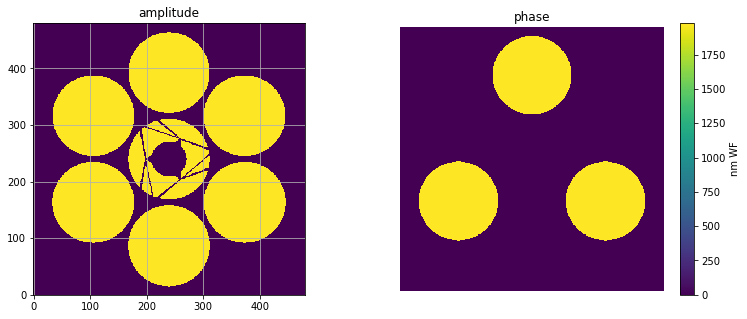

In [19]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((13,5))

ax1.imshow(src._gs.amplitude.host(), origin='lower',interpolation='None')
ax1.set_title('amplitude')
ax1.set_aspect('equal')
ax1.grid()

myopd = (opd-opd0)*src._gs.amplitude.host()*1e9
visu.show_wavefront(myopd, clb_label='nm WF', title='phase', fig=fig, ax=ax2)
print("on-axis WFE: %0.1f nm RMS"%(src.phaseRms()*1e9))

print("segment piston [nm]:", np.array_str(src.piston('segments')*1e9, precision=1, suppress_small=True))

### DFS measurements

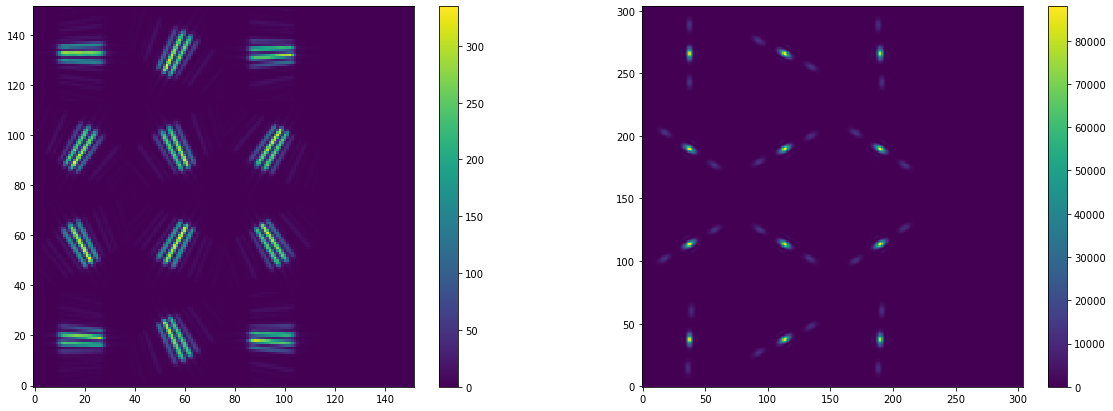

In [20]:
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((20,7))
h1 = ax1.imshow(dfs.camera.frame.host(),interpolation='None',origin='lower')
fig.colorbar(h1,ax=ax1)
h2 = ax2.imshow(dfs.fftlet.host(),interpolation='None',origin='lower')
fig.colorbar(h2,ax=ax2)

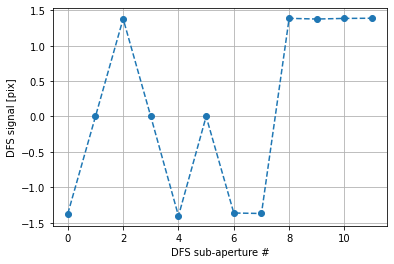

In [21]:
#-- The signals are the side-lobe displacement in pixels.
plt.plot(dfs.get_measurement(), 'o--')
plt.grid()
plt.xlabel('DFS sub-aperture #');
plt.ylabel('DFS signal [pix]');

# Interaction Matrix Calibration

## M1 PTT segment piston - DFS

In [22]:
%%time
D_spp_dfs = wfpt.calibrate(dfs, src, mirror='M1', mode='segment piston', stroke=50e-9)

___ M1 ___ (segment piston)
Segment #:1 2 3 4 5 6 7 
------------
CPU times: user 4.56 s, sys: 2.28 s, total: 6.84 s
Wall time: 6.83 s


In [23]:
#-- To convert DFS signals in pixels to nanometers of 
#-- differential piston (Surface) between adjacent segments (12 values)
DFSsig2pist = 1 / np.max(np.abs(D_spp_dfs), axis=1)  

Text(0, 0.5, 'DFS sub-aperture #')

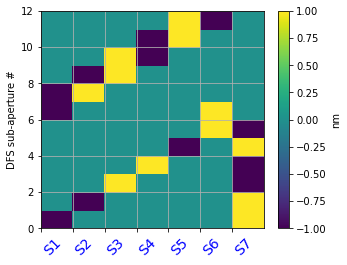

In [24]:
fig2, ax2 = plt.subplots()
fig2.set_size_inches(5,4)

imm = ax2.pcolor(D_spp_dfs * DFSsig2pist[:,np.newaxis])
ax2.grid()
ax2.set_ylim([0,12])
ax2.set_xticks(range(7))
ax2.set_xticklabels(['S1','S2','S3','S4','S5','S6','S7'], ha='left', fontsize=14, 
                    rotation=45, color='b')
fig2.colorbar(imm, ax=ax2, label='nm');
ax2.set_ylabel('DFS sub-aperture #')

## Reconstruction Matrix
Inverse of M1_DM-SH matrix

M1 PTT SPP - DFS IM:
(12, 7)
conditioning number:
994810.798181661


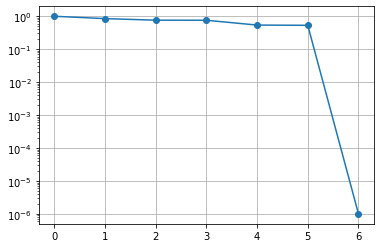

In [25]:
print('M1 PTT SPP - DFS IM:')
print(D_spp_dfs.shape)
print("conditioning number:")
print(np.linalg.cond(D_spp_dfs))

UU1, ss1, VVT1 = np.linalg.svd(D_spp_dfs, full_matrices=False)
plt.semilogy(ss1/np.max(ss1), 'o-')
plt.grid()

In [26]:
R_spp_dfs = np.linalg.pinv(D_spp_dfs, rcond=1e-3)

### Test reconstructor

Text(0, 0.5, 'segment piston [nm SURF]')

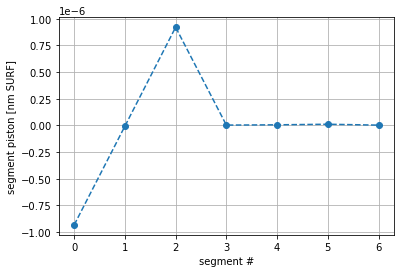

In [27]:
wfpt.reset()
state = wfpt.state
state['M1_PTT']['segment piston'][0] = -1e-6
state['M1_PTT']['segment piston'][2] = 1e-6

wfpt.update(state)

src.reset()
wfpt.propagate(src)
WFin = src._gs.phase.host()

dfs.reset()
dfs.propagate(src)
dfs.fft()
dfs.process()
dfs_meas = dfs.get_measurement()

spp_comm = R_spp_dfs @ dfs_meas

#plt.imshow(WFin-opd0, origin='lower', interpolation='None')
#plt.colorbar()
plt.plot(spp_comm, 'o--')
plt.grid()
plt.xlabel('segment #')
plt.ylabel('segment piston [nm SURF]')

# Characterize measurement noise

## Photon and Readout noise

In [31]:
#---- #---- Using a series of frames to get some DFS measurement statistics vs. exposure time
wfpt.reset()
src.reset()
wfpt.propagate(src)

niter = 100
sppvec = np.zeros((7,niter))

exposureTime = [0.001, 0.01, 0.1, 1.0, 10.0] #seconds
dfs.camera.readOutNoiseRms = 1.0 # e- rms
spprms = []

for expTime in exposureTime:
    for jj in range(niter):
        dfs.reset()
        dfs.propagate(src)
        dfs.readOut(expTime)
        dfs.fft()
        dfs.process()
        measvec = dfs.get_measurement()
        sppvec[:,jj] = R_spp_dfs @ measvec
    spprms += [np.mean(np.std(sppvec, axis=0))]

spprms = np.array(spprms)

In [32]:
#spprms_onlyPhotNoise = spprms
#spprms_phot_ron1p0 = spprms

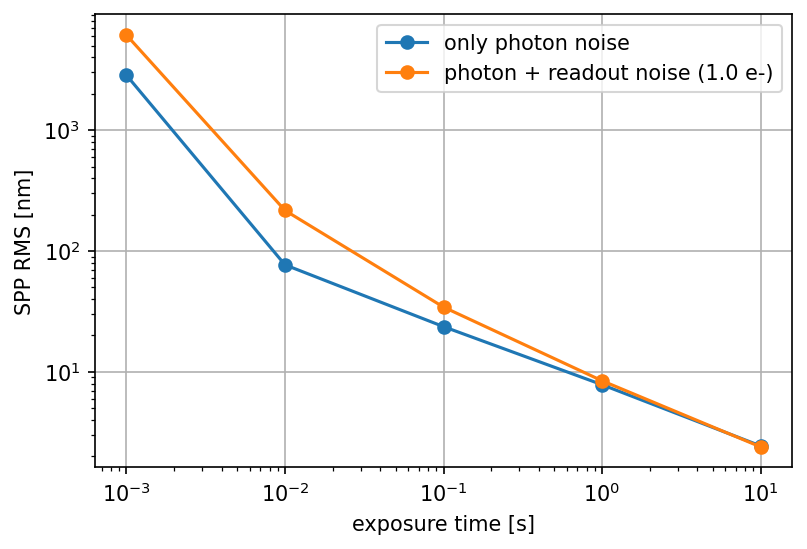

In [33]:
fig, ax = plt.subplots()
fig.dpi = 150
ax.loglog(exposureTime, spprms_onlyPhotNoise*1e9, 'o-', label='only photon noise')
ax.loglog(exposureTime, spprms_phot_ron1p0*1e9, 'o-', label='photon + readout noise (1.0 e-)')
ax.set_xlabel('exposure time [s]')
ax.set_ylabel('SPP RMS [nm]')
ax.legend()
ax.grid()

# Perform a closed-loop test
Introduce an initial scramble of segment piston, and close the loop with the PTT array.

## Introduce a scramble

In [34]:
from numpy.random import default_rng
rng = default_rng(seed=1454)

WFE: 1492.5 nm RMS


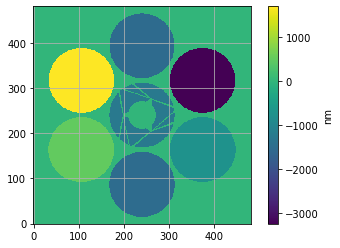

In [35]:
# Scramble:
wfpt.reset()
state0 = wfpt.state
state0['M1_PTT']['segment piston'][:] = rng.standard_normal(size=(7)) * 1e-6
wfpt.update(state0)

# Visualize the scramble
src.reset()
wfpt.propagate(src)
opd = src._gs.phase.host()
print("WFE: %0.1f nm RMS"%(src._gs.phaseRms()*1e9))
fig, ax2 = plt.subplots()
im2 = ax2.imshow((opd-opd0)*1e9, origin='lower', interpolation='None')
h2 = plt.colorbar(im2, ax=ax2, label='nm')
ax2.set_aspect('equal')
ax2.grid()

## Close the loop

In [37]:
totSimulIter = 30
gain = 0.5
tid = StopWatch()
exposureTime  = 0.1
dfs.camera.readOutNoiseRms = 1.0

M1_DM_comm_buffer = np.zeros(7)
wfe_iter = np.zeros(totSimulIter)
globpist_iter = np.zeros(totSimulIter)

In [38]:
# Get 
wfpt.reset()
state = wfpt.state

# Load initial scramble
wfpt.update(state0)

for jj in range(totSimulIter):
    tid.tic()
    src.reset()
    wfpt.propagate(src)
    wfe_iter[jj] = src._gs.wavefront.rms()
    globpist_iter[jj] = src._gs.piston()
    
    #--- WFS measurements and command
    dfs.reset()
    dfs.propagate(src)
    dfs.readOut(exposureTime)
    dfs.fft()
    dfs.process()
    measvec = dfs.get_measurement()
    M1_DM_delta_comm = R_spp_dfs @ measvec
    M1_DM_comm_buffer += gain * M1_DM_delta_comm
    
    #--- Update state vector
    state['M1_PTT']['segment piston'] = -M1_DM_comm_buffer
    wfpt.update(state0+state)

    tid.toc()
    sys.stdout.write("\r iter: %d/%d, ET: %.2f, WFE [nm WF RMS] on-axis: %0.1f"%(jj, totSimulIter, tid.elapsedTime, wfe_iter[jj]*1e9))
    sys.stdout.flush()   


 iter: 29/30, ET: 489.70, WFE [nm WF RMS] on-axis: 40.85

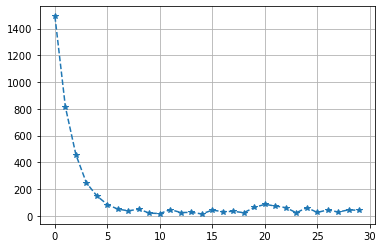

In [39]:
plt.plot(wfe_iter*1e9, '*--')
#plt.plot(globpist_iter*1e9, 'x--')
plt.grid()

WFE: 40.8 nm RMS


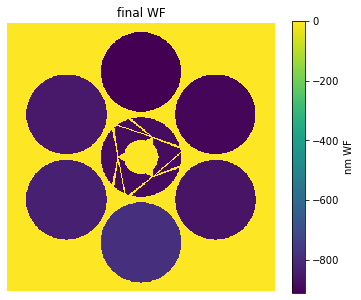

In [40]:
opd = src._gs.phase.host()

print("WFE: %0.1f nm RMS"%(src._gs.phaseRms()*1e9))
visu.show_wavefront((opd-opd0)*1e9, clb_label='nm WF', title='final WF')

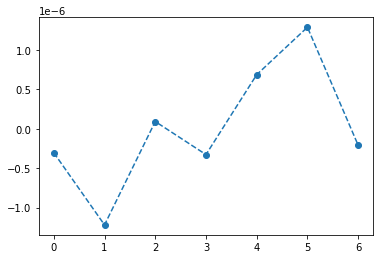

In [41]:
plt.plot(M1_DM_comm_buffer, 'o--')

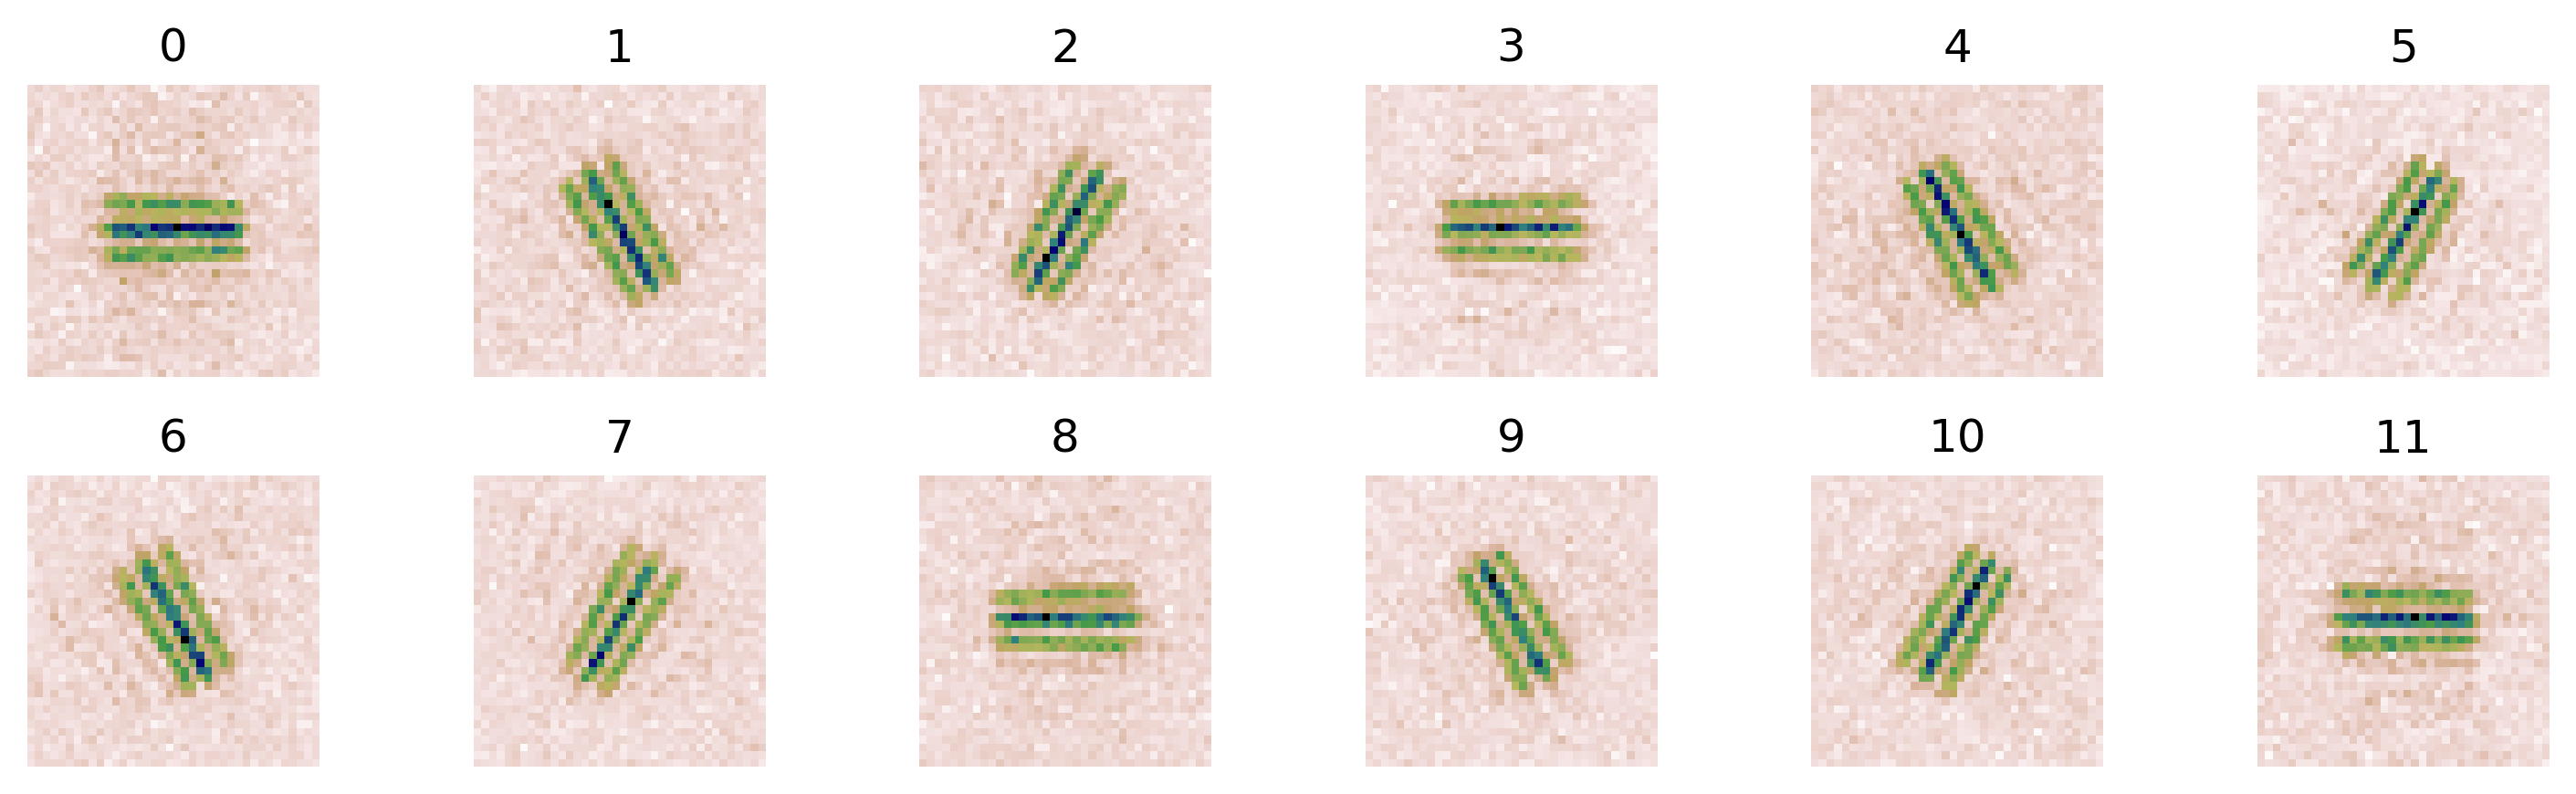

In [42]:
fringes = dfs.get_data_cube(data_type='camera')
visu.show_DFS_data(fringes)

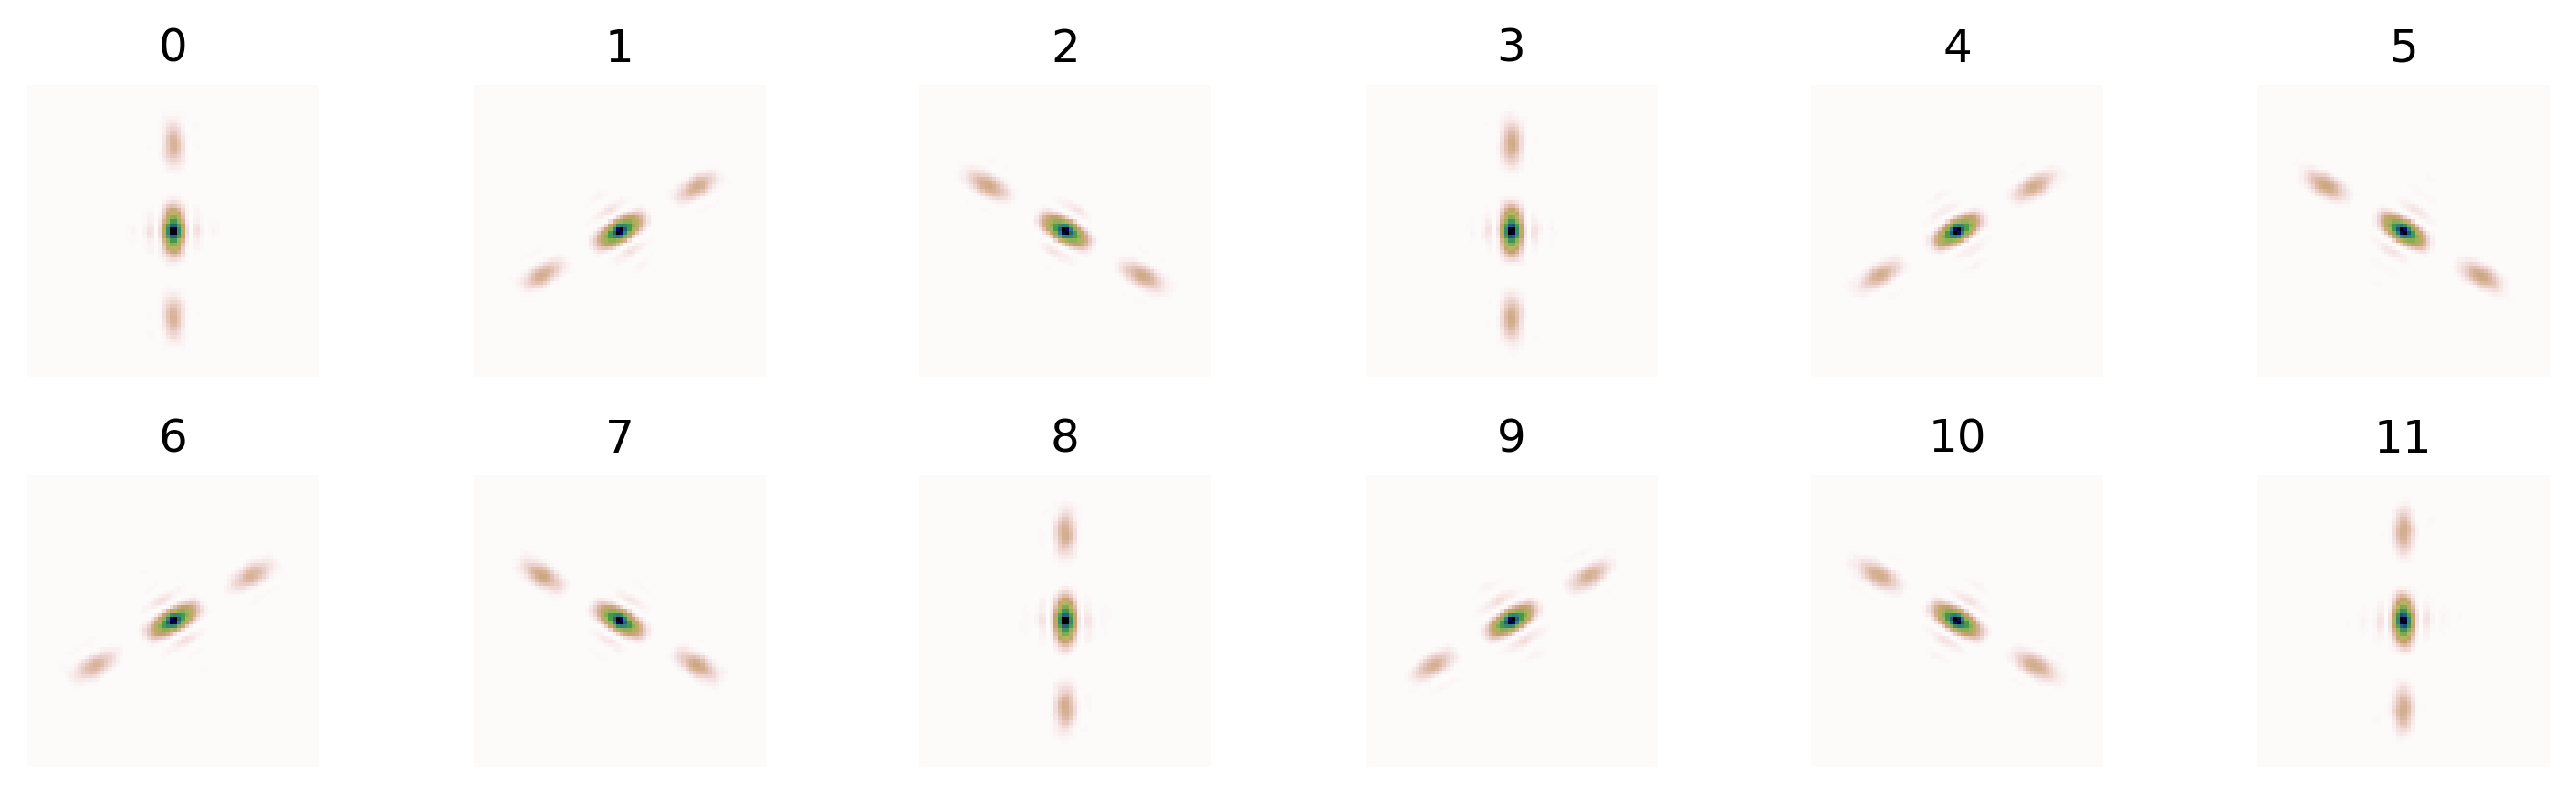

In [43]:
fftlets = dfs.get_data_cube(data_type='fftlet')
visu.show_DFS_data(fftlets)